In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/Documents/Study/Robotics/optimal_control_julia/lec_2/Project.toml`


In [2]:
using LinearAlgebra
using PyPlot
using ForwardDiff

## Define Dynamics Function

In [6]:
function pendulum_dynamics_wo_control(x)

    g = 9.81
    l = 1
    
    θ = x[1]
    θ̇ = x[2]
    θ̈ = -g/l * sin(θ)

    return [θ̇, θ̈]
end

pendulum_dynamics_wo_control (generic function with 1 method)

## Method 1. Forward Euler Integration

In [38]:
function pendulum_forward_euler(fun, x0, Tf, h)
    # julia range function reference
    #  https://docs.julialang.org/en/v1/base/math/#Base.range
    t = Array(range(0, Tf, step=h))
    
    x_hist = zeros(length(x0), length(t))
    x_hist[:,1] .= x0

    for i = 1:(length(t) -1)
        x_hist[:,i+1] .= x_hist[:,i] + h .* fun(x_hist[:,i])
    end
    
    return x_hist, t
end

pendulum_forward_euler (generic function with 1 method)

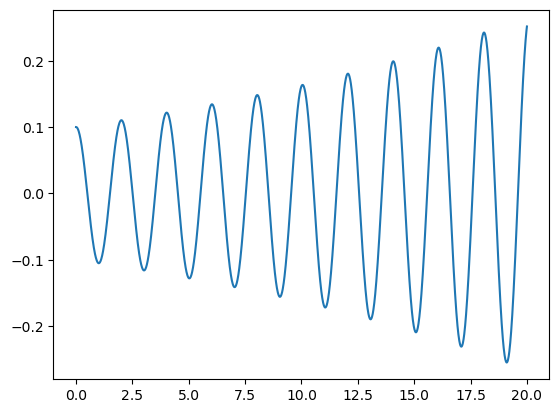

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15a066c20>

In [44]:
x0 = [0.1, 0.0]
hist, time = pendulum_forward_euler(pendulum_dynamics_wo_control, x0, 20, 0.01)
plot(time, hist[1,:])

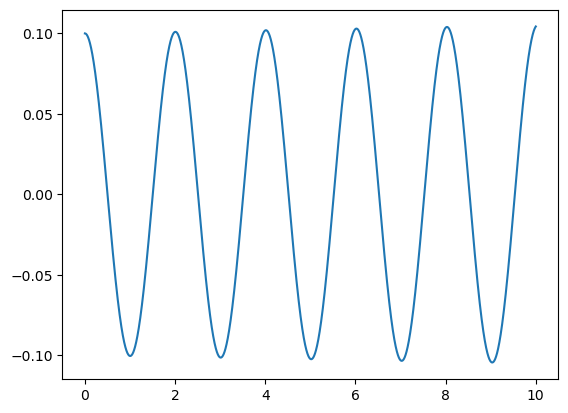

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15a0f1240>

In [45]:
x0 = [0.1, 0.0]
hist, time = pendulum_forward_euler(pendulum_dynamics_wo_control, x0, 10, 0.001)
plot(time, hist[1,:])

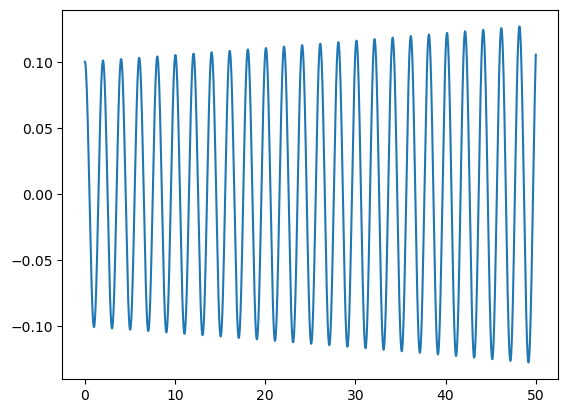

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15a14e770>

In [46]:
x0 = [0.1, 0.0]
hist, time = pendulum_forward_euler(pendulum_dynamics_wo_control, x0, 50, 0.001)
plot(time, hist[1,:])

## Eigen Value of Discretized State Space 

In [53]:
function pendulum_euler_Ad(x0, h)
    θ = x0[1]
    g = 9.81
    l = 1
    Ad = [
        1 h;
        -h*(g/l)*cos(θ) 1   
    ]
    return Ad
end 

pendulum_euler_Ad (generic function with 1 method)

In [54]:
x0 = [0.1, 0.0]
Ad = pendulum_euler_Ad(x0, 0.001)
eigvals(Ad)

2-element Vector{ComplexF64}:
 1.0 - 0.0031242584498369264im
 1.0 + 0.0031242584498369264im

## Distribution of Eigvals from 0 to 0.1 

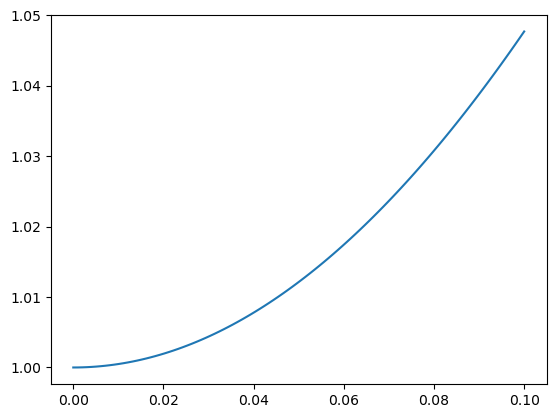

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15a33d660>

In [62]:
eignorms = zeros(100)
# LinRange Reference
# https://docs.julialang.org/en/v1/base/collections/
h = LinRange(0, 0.1, 100)
x0 = [0.1, 0.0]

for i in 1:length(eignorms)
    eignorms[i] = max(norm.(eigvals(pendulum_euler_Ad(x0, h[i])))...)
end
plot(h, eignorms)

## Method 2. RK 4 - A Better Explicit Integrator

In [89]:
function pendulum_rk4(fun, x0, Tf, h)

    t = Array(range(0, Tf, step=h))
    
    x_hist = zeros(length(x0), length(t))
    x_hist[:,1] .= x0

    for i = 1:(length(t)-1)
        k1 = fun(x_hist[:,i])
        k2 = fun(x_hist[:,i] + h * 0.5 * k1)
        k3 = fun(x_hist[:,i] + h * 0.5 * k2)
        k4 = fun(x_hist[:,i] + h * k3)
        x_hist[:,i+1] .= x_hist[:,i] + h/6.0 * (k1 + 2*k2 + 2*k3 + k4)
    end
    
    return x_hist, t
    
end

pendulum_rk4 (generic function with 1 method)

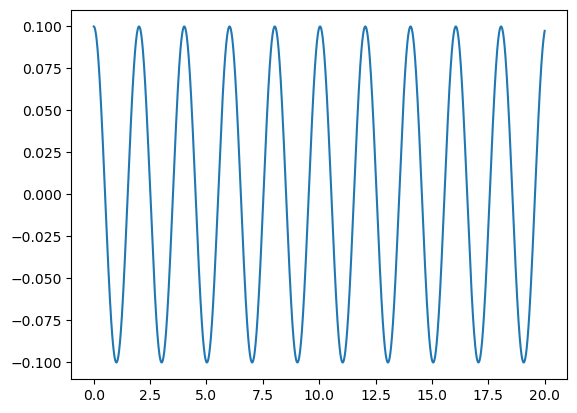

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15a872c20>

In [92]:
x0 = [0.1, 0.0]
hist, time = pendulum_rk4(pendulum_dynamics_wo_control, x0, 20, 0.01)
plot(time, hist[1,:])

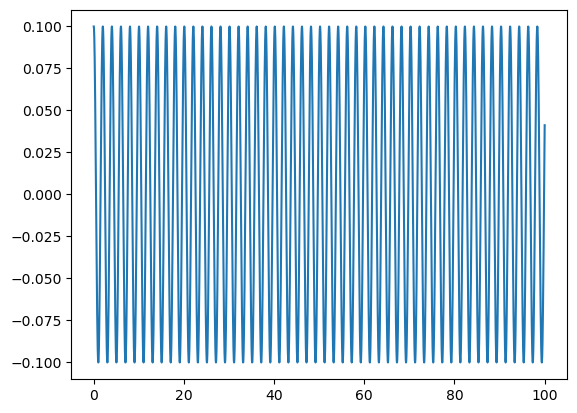

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15a989cc0>

In [94]:
x0 = [0.1, 0.0]
hist, time = pendulum_rk4(pendulum_dynamics_wo_control, x0, 100, 0.01)
plot(time, hist[1,:])

## Eigen Value of Discretized State Space 

In [96]:
function rk4(fun, xk, h)
    
    k1 = fun(xk)
    k2 = fun(xk + h * 0.5 * k1)
    k3 = fun(xk + h * 0.5 * k2)
    k4 = fun(xk + h * k3)

    return xk + h/6.0 * (k1 + 2*k2 + 2*k3 + k4)
end

x0 = [0.1, 0.0]
Ad = ForwardDiff.jacobian( x -> rk4(pendulum_dynamics_wo_control, x, 0.1), x0)

2×2 Matrix{Float64}:
  0.951588  0.098373
 -0.960371  0.95158

In [98]:
norm.(eigvals(Ad))

2-element Vector{Float64}:
 0.9999936323080544
 0.9999936323080544

## Distribution of Eigvals from 0 to 1

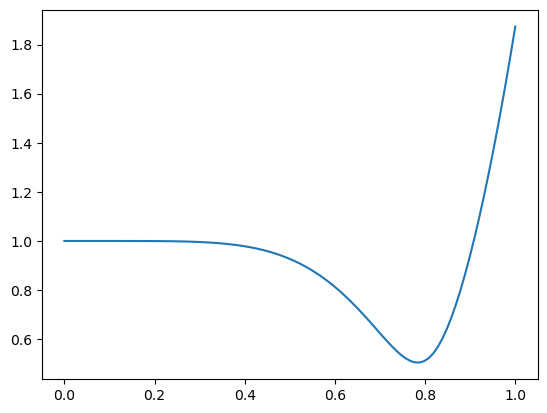

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15ab04640>

In [101]:
eignorms = zeros(100)
h = LinRange(0, 1, 100)
x0 = [0.1, 0.0]

for i in 1:length(eignorms)
    eignorms[i] = max(norm.(eigvals(ForwardDiff.jacobian( x -> rk4(pendulum_dynamics_wo_control, x, h[i]), x0)))...)
end
plot(h, eignorms)

### There's downhill curve around h=0.8, that point will converge more faster

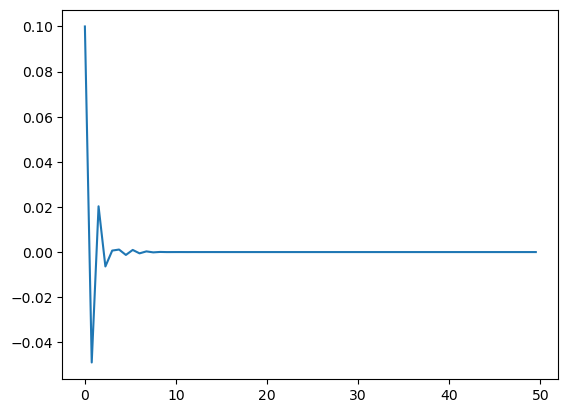

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15add3af0>

In [105]:
x0 = [0.1, 0.0]
h = 0.75
hist, time = pendulum_rk4(pendulum_dynamics_wo_control, x0, 50, h)
plot(time, hist[1,:])

### What about point around 1.0?

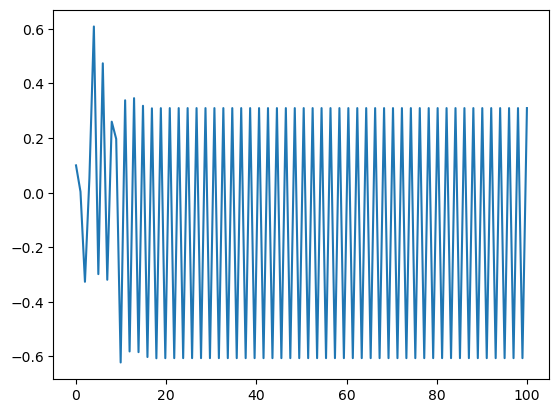

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15b2ca080>

In [116]:
x0 = [0.1, 0.0]
h = 0.99
hist, time = pendulum_rk4(pendulum_dynamics_wo_control, x0, 100, h)
plot(time, hist[1,:])

## Method 3. Backward Euler Integration - Implicit Method

In [133]:
function pendulum_backward_euler(fun, x0, Tf, h)

    t = Array(range(0, Tf, step=h))
    
    x_hist = zeros(length(x0), length(t))
    x_hist[:,1] .= x0

    for i = 1:(length(t)-1)

        e = 1.0
        x_hist[:,i+1] .= x_hist[:,i]

        while e > 1e-8
            xn = x_hist[:,i] + h .* fun(x_hist[:,i+1])
            e = norm(xn - x_hist[:,i+1])
            x_hist[:,i+1] = xn
        end
    end
    
    return x_hist, t
end

pendulum_backward_euler (generic function with 1 method)

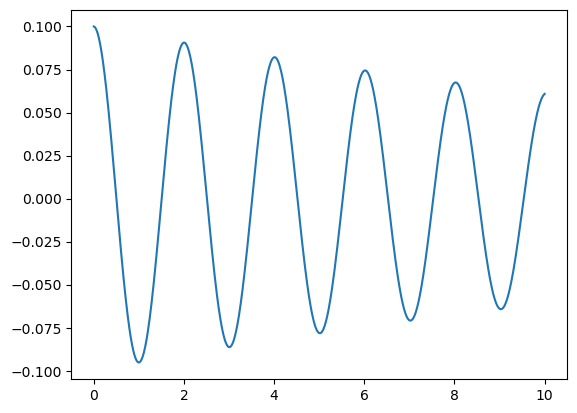

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15b50eb90>

In [134]:
x0 = [0.1, 0.0]
hist, time = pendulum_backward_euler(pendulum_dynamics_wo_control, x0, 10, 0.01)
plot(time, hist[1,:])

## Backward Euler Integration is always stable (in terms of convergence)

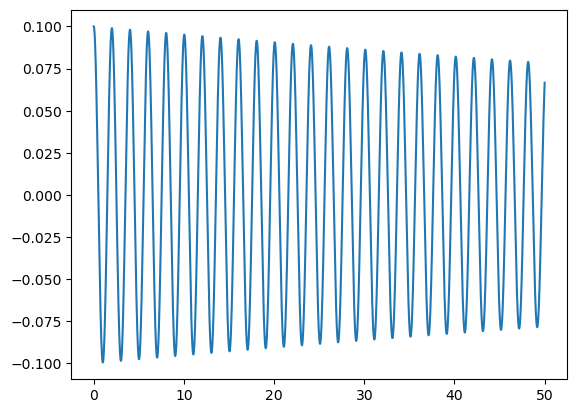

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15bc95d20>

In [149]:
x0 = [0.1, 0.0]
hist, time = pendulum_backward_euler(pendulum_dynamics_wo_control, x0, 50, 0.001)
plot(time, hist[1,:])

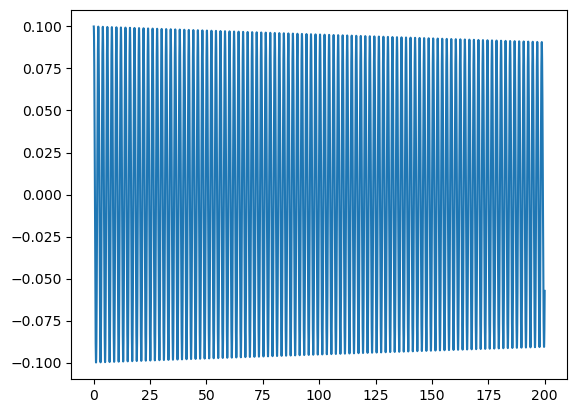

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15bea0940>

In [153]:
x0 = [0.1, 0.0]
hist, time = pendulum_backward_euler(pendulum_dynamics_wo_control, x0, 100, 0.0001)
plot(time, hist[1,:])